# H3-Pandas Intro

In [ ]:
pip install h3pandas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import h3pandas

## Fetch data

We will use the NYC Taxi dataset for this demo

In [2]:
# Download and subset data
df = pd.read_csv('https://github.com/uber-web/kepler.gl-data/raw/master/nyctrips/data.csv')
df = df.rename({'pickup_longitude': 'lng', 'pickup_latitude': 'lat'}, axis=1)[['lng', 'lat', 'passenger_count']]

Only use the central part of the data

In [3]:
qt = 0.1
df = df.loc[(df['lng'] > df['lng'].quantile(qt)) & (df['lng'] < df['lng'].quantile(1-qt)) 
            & (df['lat'] > df['lat'].quantile(qt)) & (df['lat'] < df['lat'].quantile(1-qt))]

## H3-Pandas

### Basic H3 API

#### `geo_to_h3`

We can use `geo_to_h3` to add an index with H3 addresses resolution 10

**NOTE**: `geo_to_h3` also works with `POINT` GeoDataFrames

In [4]:
dfh3 = df.h3.geo_to_h3(10)
dfh3.head()

,lng,lat,passenger_count
h3_10,,,
8a2a100d2c87fff,-73.993896,40.750111,1
8a2a100d2a07fff,-73.976425,40.739811,1
8a2a100d630ffff,-73.968704,40.754246,5
8a2a100d629ffff,-73.976601,40.751896,1
8a2a100d2557fff,-73.994957,40.745079,1


<AxesSubplot:xlabel='lng', ylabel='lat'>

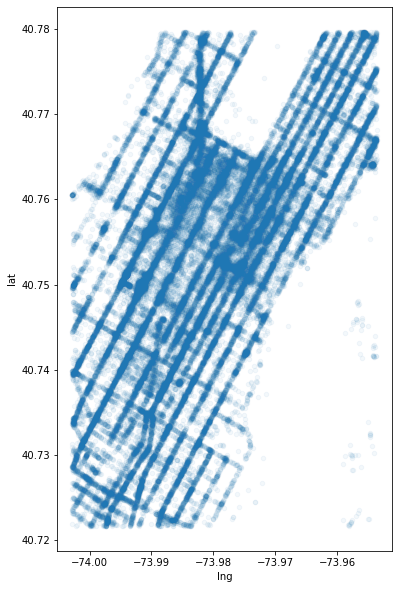

In [5]:
df.plot.scatter(x='lng', y='lat', figsize=(6,10), alpha=0.05)

#### `h3_to_geo_boundary()`

We can see how many passengers fall into each H3 hexagon.

For now, we will pretend H3-Pandas do not have [aggregation functions](#Aggregation-functions) and perform the aggregations manually

In [6]:
dfh3 = dfh3.drop(columns=['lng', 'lat']).groupby('h3_10').sum()

We can now add a H3 hexagonal geometry to each row

In [7]:
gdfh3 = dfh3.h3.h3_to_geo_boundary()
gdfh3.head()

,passenger_count,geometry
h3_10,,
8a2a10089007fff,17,"POLYGON ((-73.95877 40.78037, -73.95969 40.780..."
8a2a1008900ffff,110,"POLYGON ((-73.95843 40.77924, -73.95934 40.779..."
8a2a10089017fff,9,"POLYGON ((-73.96032 40.78070, -73.96123 40.780..."
8a2a1008901ffff,97,"POLYGON ((-73.95997 40.77958, -73.96088 40.779..."
8a2a1008902ffff,117,"POLYGON ((-73.95723 40.78003, -73.95814 40.779..."


<AxesSubplot:>

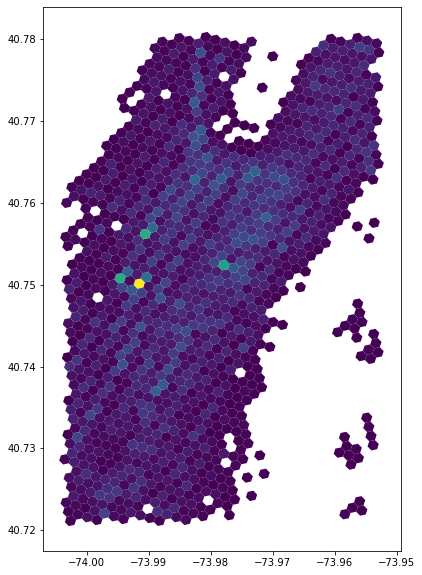

In [8]:
gdfh3.plot(column='passenger_count', figsize=(10, 10))

#### `h3_to_parent`

If we want to perform the analysis on a coarser resolution, we can use `h3_to_parent`

In [9]:
gdfh3_9 = gdfh3.h3.h3_to_parent(9)
gdfh3_9.head()

,passenger_count,geometry,h3_09
h3_10,,,
8a2a10089007fff,17,"POLYGON ((-73.95877 40.78037, -73.95969 40.780...",892a1008903ffff
8a2a1008900ffff,110,"POLYGON ((-73.95843 40.77924, -73.95934 40.779...",892a1008903ffff
8a2a10089017fff,9,"POLYGON ((-73.96032 40.78070, -73.96123 40.780...",892a1008903ffff
8a2a1008901ffff,97,"POLYGON ((-73.95997 40.77958, -73.96088 40.779...",892a1008903ffff
8a2a1008902ffff,117,"POLYGON ((-73.95723 40.78003, -73.95814 40.779...",892a1008903ffff


Again, we pretend that we cannot use [aggregation functions](#Aggregation-functions) and perform the operations manually.

In [10]:
gdfh3_9 = gdfh3_9.set_index('h3_09').groupby('h3_09').sum().h3.h3_to_geo_boundary()
gdfh3_9.head()

,passenger_count,geometry
h3_09,,
892a1008903ffff,350,"POLYGON ((-73.95912 40.78149, -73.96123 40.780..."
892a1008907ffff,611,"POLYGON ((-73.95688 40.77891, -73.95899 40.777..."
892a100890bffff,286,"POLYGON ((-73.96340 40.78138, -73.96551 40.780..."
892a100890fffff,686,"POLYGON ((-73.96116 40.77879, -73.96327 40.777..."
892a1008917ffff,544,"POLYGON ((-73.95485 40.78160, -73.95695 40.780..."


<AxesSubplot:>

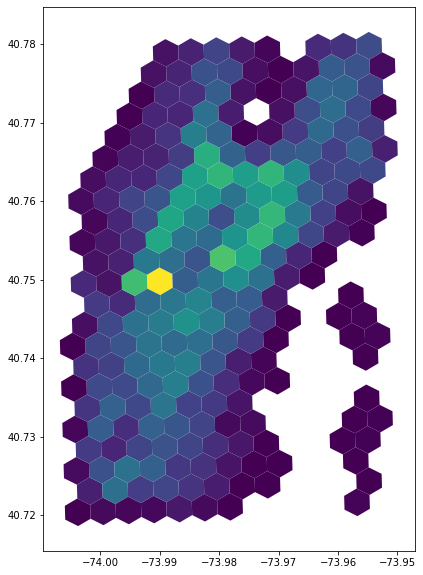

In [11]:
gdfh3_9.plot(column='passenger_count', figsize=(10, 10))

## H3-Pandas Extended API: The same workflow, streamlined

The entire above workflow can be performed in one line using aggregation functions of H3-Pandas, namely
- `h3.geo_to_h3_aggregate`
- `h3.h3_to_parent_aggregate`

In [12]:
gdfh3_9_alt = df.h3.geo_to_h3_aggregate(10, return_geometry=False).h3.h3_to_parent_aggregate(9)

<AxesSubplot:>

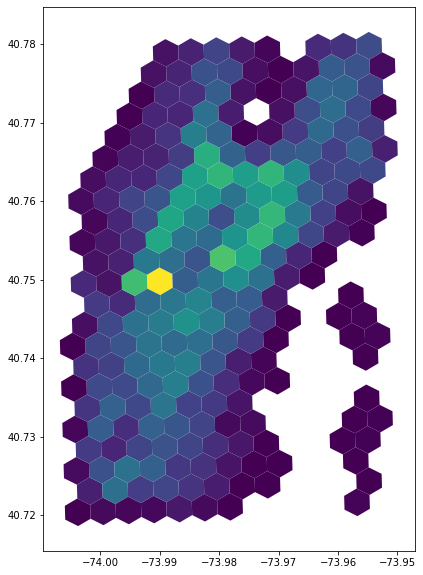

In [13]:
gdfh3_9_alt.plot(column='passenger_count', figsize=(10, 10))